In [1]:
# pyright: reportUnusedExpression=false, reportDuplicateImport=false, reportUnusedImport=false, reportMissingImports=false, reportCallIssue=false, reportRedeclaration=false
# mypy: disable-error-code="no-untyped-def, no-untyped-call, assignment, no-redef"

import warnings

warnings.filterwarnings("ignore")

import numpy as np

np.set_printoptions(legacy="1.25")

# Why `tmmc-lnpy`?

:::{note}
While the distribution is named `tmmc-lnpy`, it provides the python package {mod}`lnpy`.  This naming was done to avoid conflicts with other packages on pypi.   The name of the module {mod}`lnpy` may be changed in the future.
:::


{mod}`lnpy` is a python package to analyze the main output of Grand Canonical Transition Matrix Monte Carlo (GC-TMMC) simulations: $\ln \Pi(N)$.  Hence the name. {mod}`lnpy` is designed to calculate a host of properties in the Canonical and Grand Canonical ensembles.   For a review of GC-TMMC and the property $\ln \Pi(N)$, look at some of the following references:


* [Evaluating surface tension using grand-canonical transition-matrix Monte Carlo simulation and finite-size scaling](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.67.012102)
* [Direct evaluation of multicomponent phase equilibria using flat-histogram methods](http://dx.doi.org/10.1063/1.2064628)
* [Direct calculation of liquid--vapor phase equilibria from transition matrix Monte Carlo simulation](https://aip.scitation.org/doi/10.1063/1.1572463)
* [Metastability and instability in the Lennard-Jones fluid investigated by transition-matrix Monte Carlo](https://pubs.acs.org/doi/10.1021/jp040218y)


$\Pi(N; \mu, T, V)$ is the macrostate probability of observing $N$ particles at a given chemical potential $\mu$, temperature $T$ and volume $V$.  We drop the explicit mention of $\mu$, $V$ and $T$ below for simplicity.  This distribution is related to the grand canonical ensemble by:

$$ \Pi(N) = \frac{\exp(\beta \mu N) Q(N, V, T)}{\Xi(\mu, V, T)}$$

Where $\beta = 1 / (k_{\rm B} T)$ is the inverse temperature, $k_{\rm B}$ is Boltzmann's constant, $Q(N, V, T)$ is the canonical partition function, and $\Xi(\mu, V, T)$ is the grand canonical partition function.   GC-TMMC simulation provide a means to calculate the $\ln \Pi(N; \mu, V, T)$ directly.  One of the truly excellent qualities of such simulations is that once $\ln \Pi$ is collected at a given chemical potential $\mu_0$, it can be rescaled to any other chemical potential $\mu$ through rescaling of the form:

$$ \ln \Pi(N; \mu, V, T) = \ln \Pi(N; \mu_0, V, T) + \beta N (\mu - \mu_0) + C $$

where $C$ is a normalization constant which does not effect most calculated properties.  From $\ln \Pi(N)$, many thermodynamic properties can be calculated.  The grand potential $\Omega$, and hence the system pressure $p$, can be obtained from 

$$ \beta \Omega = -\beta p V = \ln \Pi(0) + \ln \left[\sum_N \Pi(N, \mu, V, T) \right]$$


Also, grand canonical averages can be calculated from canonical averages using $\ln \Pi(N)$:

$$ \overline{X} = \frac{\sum_N \Pi(N) X(N)}{\sum_N \Pi(N)} $$


Plus, $\ln \Pi$ can be directly analyzed to identify unique phases, phase transitions, limits of stability, etc.  The package {mod}`lnpy` provides a simple means to perform all the above calculations simply, and quickly.  




# Usage

Lets consider a simple example: a Lennard-Jones (LJ) fluid at supercritical temperatures.  
An example value of $\ln \Pi(N)$ (shortened to `lnPi`) can be loaded directly from {mod}`lnpy` package:

In [2]:
import numpy as np

import lnpy.examples

data_dict = lnpy.examples.load_example_dict("lj_sup")
with np.printoptions(precision=2, suppress=True, threshold=5):
    for k, v in data_dict.items():
        print(f"{k}:{v!r}")

lnPi_data:array([-1559.75, -1550.74, -1542.43, ...,   -10.01,   -11.02,   -12.08])
lnPi_mask:array([False, False, False, ..., False, False, False])
state_kws:{'beta': 0.6666666666666666, 'volume': 512.0}
extra_kws:{'PE': array([    0.  ,     0.  ,    -0.02, ..., -1643.18, -1648.71, -1654.36])}
lnz:array([2.77])


Here, we have the parameters

* lnPi_data: the actual value of $\ln \Pi(N)$.
* lnPi_mask: bool array.  where `mask == True`, values are 'masked out'
* state_kws: dict of 'state' variables. Here, it include the inverse temperature 'beta' $=\beta = 1/(k_{\rm B} T)$
  and the systems volume 'volume' $=V$
* extra_kws: dict of 'extra' variables.  Here, it include 'PE', the canonical potential energy
* lnz: log of activity $\ln z = \beta \mu$, where $\mu$ is chemical potential.


## lnPiMasked

The first important class is {class}`~lnpy.lnpidata.lnPiMasked`.  This class handles the basics of dealing with $\ln \Pi(N)$. To create it, to the following.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

ref = lnpy.lnPiMasked.from_data(
    lnz=data_dict["lnz"],
    lnz_data=data_dict["lnz"],
    data=data_dict["lnPi_data"],
    mask=data_dict["lnPi_mask"],
    state_kws=data_dict["state_kws"],
    extra_kws=data_dict["extra_kws"],
)
ref

<lnPi(lnz=[2.76512052])>

To access the underlying data, use the following

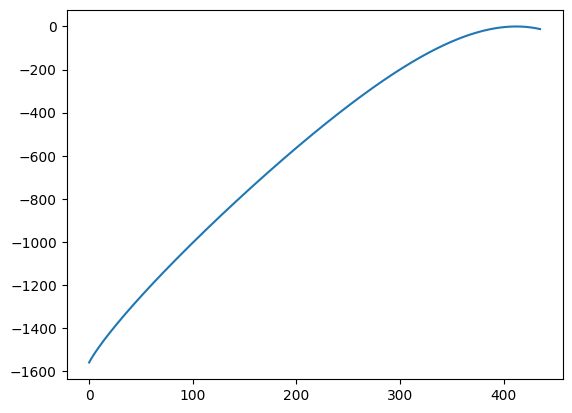

In [4]:
plt.plot(ref.data)

## Reweighting results

One of the amazing things about $\ln \Pi(N)$ calculated at some chemical potential $\mu_{\rm ref}$ is that it can be 
reweighted to any other chemical potential $\mu$.  This is done with the formula

$$
\ln \Pi(N, \mu) = \ln \Pi(N, \mu_{\rm ref}) + \beta (\mu - \mu_{\rm ref}) N
$$

To reweight data to another value of $\ln z$, we use the {meth}`lnpy.lnpidata.lnPiMasked.reweight` method:

<lnPi(lnz=[4.])>


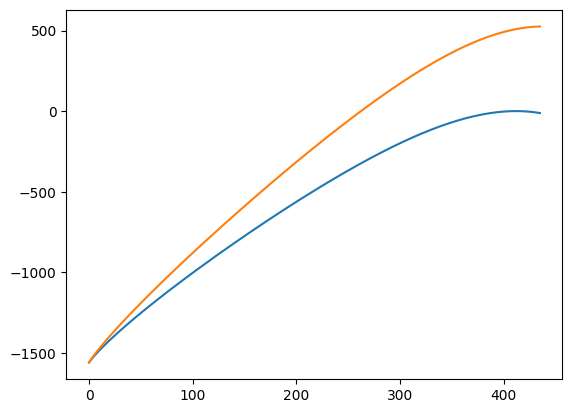

In [5]:
new = ref.reweight(4.0)
print(new)

# compare to original
plt.plot(ref.data, label=ref.lnz)
plt.plot(new.data, label=new.lnz)

{class}`lnpy.lnpidata.lnPiMasked` has a variety of utilities to work with the $\ln \Pi(N)$ data. For example

* zeromax: shift $\ln \Pi(N)$ such that maximum value is zero.  Useful for numerical stability
* ma : `MaskedArray` view of data.  Used when constructing phases, and working with multicomponent data.
* 

Check out the api docs for further details

## Calculating Ensemble properties


$\ln \Pi(N)$ can be used to calculate a variety of properties in the Canonical and Grand Canonical ensembles.
To make everything easier, the actual value of $\ln \Pi(N)$ is wrapped in an DataArray object, which provides some nice data goodies.  To access this view, use the {attr}`~lnpy.lnpidata.lnPiMasked.xce` or {attr}`~lnpy.lnpidata.lnPiMasked.xge` accessors (short for Xarray Canonical Ensemble and Xarray Grand canonical Ensemble).  For example, the canonical properties can be obtained as follows:

:::{note}
We only show a small subset of functionality.  For further information, see {class}`~lnpy.lnpidata.lnPiMasked`.
:::

In [6]:
# pressure
ref.xce.pressure().head()

<xarray.DataArray 'pressure' (n_0: 5)> Size: 40B
array([-0.        ,  0.00100796,  0.00319043,  0.00560728,  0.00813105])
Coordinates:
    beta     float64 8B 0.6667
    volume   float64 8B 512.0
  * n_0      (n_0) int64 40B 0 1 2 3 4
Attributes:
    long_name:  $p({\bf n},V,T)$

In [7]:
#  scaled Helmholtz free energy
ref.xce.betaF().head()

<xarray.DataArray 'betaF' (n_0: 5)> Size: 40B
array([  0.        ,  -6.23817948, -11.78825896, -16.93743845,
       -21.80391793])
Coordinates:
    beta     float64 8B 0.6667
    volume   float64 8B 512.0
  * n_0      (n_0) int64 40B 0 1 2 3 4
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    standard_name:  helmholtz_free_energy
    long_name:      $\beta F({\bf n},V,T)$

Look at the documentation for all the properties available.  To quickly construct a dataset of multiple properties, use the `table` method.

In [8]:
ds = ref.xce.table(keys=["pressure", "betaF"], default_keys=None)
ds

<xarray.Dataset> Size: 10kB
Dimensions:   (n_0: 436)
Coordinates:
    beta      float64 8B 0.6667
    volume    float64 8B 512.0
  * n_0       (n_0) int64 3kB 0 1 2 3 4 5 6 7 ... 429 430 431 432 433 434 435
Data variables:
    pressure  (n_0) float64 3kB -0.0 0.001008 0.00319 ... 5.786 5.854 5.893
    betaF     (n_0) float64 3kB 0.0 -6.238 -11.79 ... -352.4 -348.7 -344.8
Attributes:
    long_name:  $p({\bf n},V,T)$

This can be easily converted to a `pandas.DataFrame`

In [9]:
ds.to_dataframe().head()

,beta,volume,pressure,betaF
n_0,,,,
0,0.666667,512.0,-0.000000,0.000000
1,0.666667,512.0,0.001008,-6.238179
2,0.666667,512.0,0.003190,-11.788259
3,0.666667,512.0,0.005607,-16.937438
4,0.666667,512.0,0.008131,-21.803918


To access Grand Canonical properties, use the `xge` accessor

In [10]:
ref.xge.pressure()

<xarray.DataArray 'pressure' ()> Size: 8B
array(4.57687966)
Coordinates:
    lnz_0    float64 8B 2.765
    beta     float64 8B 0.6667
    volume   float64 8B 512.0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    long_name:   $p(\mu,V,T)$

In [11]:
ref.xge.betaF()

<xarray.DataArray 'betaF' ()> Size: 8B
array(-423.16867869)
Coordinates:
    lnz_0    float64 8B 2.765
    beta     float64 8B 0.6667
    volume   float64 8B 512.0
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    standard_name:  helmholtz_free_energy
    long_name:      $\beta F(\mu,V,T)$

Or, to calculate multiple properties, again, use the `table` method

In [12]:
ref.xge.table(keys=["pressure", "betaF"], default_keys=None)

<xarray.Dataset> Size: 40B
Dimensions:   ()
Coordinates:
    lnz_0     float64 8B 2.765
    beta      float64 8B 0.6667
    volume    float64 8B 512.0
Data variables:
    pressure  float64 8B 4.577
    betaF     float64 8B -423.2
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    long_name:   $p(\mu,V,T)$

The great thing about using the xarray interface is that things like plotting become trivial.  For example, use

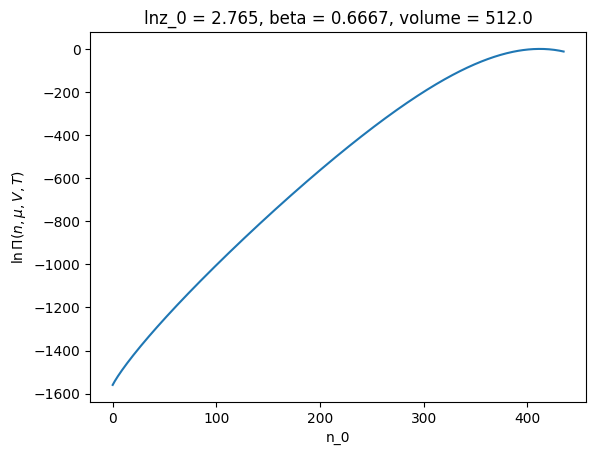

In [13]:
ref.xge.lnpi().plot()

# Collections of lnPi Values

Ok, we can reweight a $\ln \Pi(N)$ from one chemical potential to another, and calculate a variety of properties for a $\ln \Pi(N)$.  But what if we want to calculate properties at a variety of values of $\ln z$.  We could do list comprehension, but that's slow, and can get unwieldy.  Instead, `lnpy` provides a helper class to deal with multiple `lnPi`s.  To use it, we must first have a {class}`~lnpy.segment.PhaseCreator` object.  We will discuss this object in detail later, but for now, know that for the simple case of a single component system that does not have any phase transitions, it suffices to use the following.

In [14]:
phase_creator = lnpy.PhaseCreator(nmax=1, ref=ref)

build_phases = phase_creator.build_phases_mu([None])

To create a collection of with of `lnPi` at different values of `lnz`, use the {class}`lnpy.lnpiseries.lnPiCollection` class:

In [15]:
with lnpy.set_options(tqdm_leave=True):
    c = lnpy.lnPiCollection.from_builder(
        lnzs=np.linspace(-10, 3, 2000), build_phases=build_phases
    )

build:   0%|          | 0/2000 [00:00<?, ?it/s]

{class}`~lnpy.lnpiseries.lnPiCollection` is a wrapper around `pandas.Series`.  This provides an index for each {class}`~lnpy.lnpidata.lnPiMasked` instance.  This
allows some niceties like indexing by value, groupby, etc.

In [16]:
# Select by position
# scalar index gives object
c.iloc[1]

<lnPi(lnz=[-9.99349675])>

In [17]:
# array-like gives lnPiCollection instance
(c.iloc[[1]])

<class lnPiCollection>
lnz_0      phase
-9.993497  0        [-9.993496748374188]
dtype: object

In [18]:
# select by value.  Same as indexing into pandas.Series
c.loc[[3.0]]

<class lnPiCollection>
lnz_0  phase
3.0    0        [3.0]
dtype: object

In [19]:
# can also query
c.query("lnz_0 > 2.95")

<class lnPiCollection>
lnz_0     phase
2.954477  0         [2.95447723861931]
2.960980  0        [2.960980490245122]
2.967484  0        [2.967483741870936]
2.973987  0        [2.973986993496748]
2.980490  0        [2.980490245122562]
2.986993  0        [2.986993496748374]
2.993497  0        [2.993496748374188]
3.000000  0                      [3.0]
dtype: object

## Accessing properties of collection

The really nice thing about {class}`~lnpy.lnpiseries.lnPiCollection` is that all the properties for *all* the {class}`~lnpy.lnpidata.lnPiMasked` objects can be calculated at once, in a vectorized way.  The same accessor {attr}`~lnpy.lnpiseries.lnPiCollection.xge` is available to {class}`~lnpy.lnpiseries.lnPiCollection` as for {class}`~lnpy.lnpidata.lnPiMasked`.  Note that the `xce` accessor is not available, as it only makes sense for a single value of `lnPiMasked`.  

In [20]:
# Note the smart indexing.  The index is inherited from lnPiCollection.index
c.xge.pressure()

pi_norm:   0%|          | 0/2000 [00:00<?, ?it/s]

<xarray.DataArray 'pressure' (lnz_0: 2000, phase: 1)> Size: 16kB
array([[6.80940123e-05],
       [6.85383141e-05],
       [6.89855151e-05],
       ...,
       [4.84631185e+00],
       [4.85425839e+00],
       [4.86220769e+00]])
Coordinates:
  * lnz_0    (lnz_0) float64 16kB -10.0 -9.993 -9.987 -9.98 ... 2.987 2.993 3.0
  * phase    (phase) int64 8B 0
    beta     float64 8B 0.6667
    volume   float64 8B 512.0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   $p(\mu,V,T)$

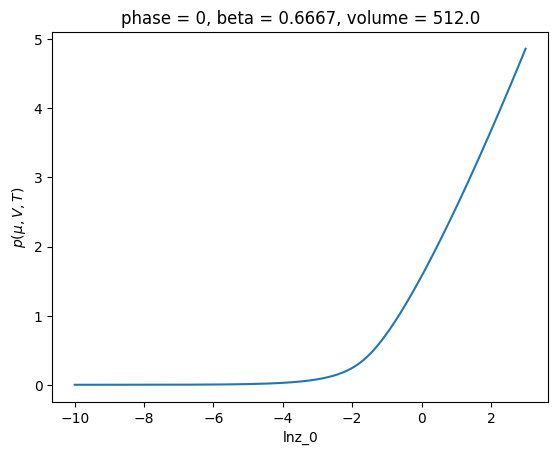

In [21]:
# plot the results
c.xge.pressure().plot()

This is much more convenient (and much faster) than doing something like:

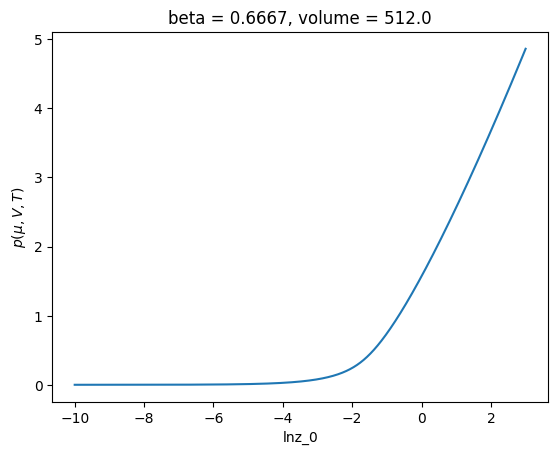

In [22]:
# Don't do things like this
# It's super slow
import xarray as xr

pressures = [x.xge.pressure() for x in c]

xr.concat(pressures, dim="lnz_0").plot()

# Loading examples

lnPi comes with some pre-defined examples in the {mod}`~lnpy.examples` module.  We used it above to load a dictionary of data that we then turned into a {class}`~lnpy.lnpidata.lnPiMasked` object.  This can be streamlined using the following:

In [23]:
import lnpy.examples

ref = lnpy.examples.load_example_lnpimasked("lj_sup")
ref

<lnPi(lnz=[2.76512052])>

Alternatively, for some examples, you can load an object with contains a predefined {class}`~lnpy.segment.PhaseCreator` object.  We'll save this for later.

# Single component system with phase transitions.

Next, let's consider a system with a phase transition. First, lets load some example data

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import lnpy
import lnpy.examples

# Subcritical LJ data
ref = lnpy.examples.load_example_lnpimasked("lj_sub")

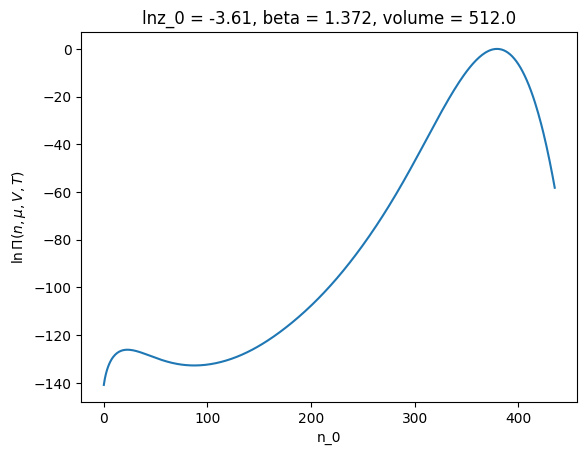

In [25]:
# look at the lnPi values
ref.xge.lnpi().plot()

Notice that this $\ln \Pi(N)$ has multiple maxima.  This indicates that multiple phases coexist.  
So calculating properties from the total {mod}`~lnpy.lnpidata.lnPiMasked` doesn't make sense.  Instead, the {class}`~lnpy.lnpidata.lnPiMasked` should be divided into phases.  The division should be at the local minima in $\ln \Pi(N)$ (at approximately `n_0=100` in the example above).  To perform the segmentation, we turn back to the {class}`~lnpy.segment.PhaseCreator` object.  Let see how this works

In [26]:
# This creates a `PhaseCreator` object
phase_creator = lnpy.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.8})

In [27]:
# call the `build_phases` method creates a lnPiCollection of phases
p = phase_creator.build_phases()
p

<class lnPiCollection>
lnz_0      phase
-3.609956  0        [-3.6099564097351307]
           1        [-3.6099564097351307]
dtype: object

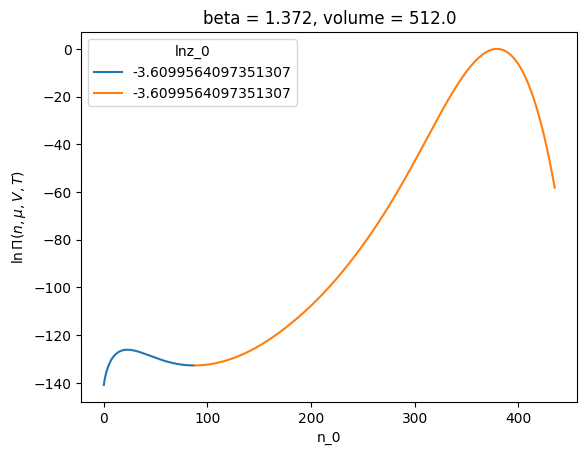

In [28]:
# plot the lnpi values for each 'phase'
p.xge.lnpi().plot(hue="lnz_0")

What just happened?  To segment $\ln \Pi(N)$ the code does the following:, we   For this we do the following

1. Find the local maxima of the $\ln \Pi(N)$.  This is done using {func}`~lnpy.segment.peak_local_max_adaptive`, which is an an adaptive version of {func}`skimage.feature.peak_local_max`.  This finds at most `nmax_peak`.  Note that `nmax_peak` can be any number.
2. Use the {func}`~skimage.segmentation.watershed` segmentation algorithm to segment $-\ln \Pi$ into regions about the local minima in $-\ln \Pi$ (local maxima in $\ln \Pi$). 
3. Remove any phases that have to low a transition energy.  We discuss this further below.
4. If the number of 'phases' is greater than the maximum allowed number of phases.  Merge them.  This is done by analyzing the transition energy between phases.  Discussed further below.
5. Merge phases that have same `phase_id`.  Discussed further below.
6. Pass list of {class}`~lnpy.lnpidata.lnPiMasked` objects and created `index` to `phases_factory` function. Discussed further below.
7. return result


OK, that's a bunch of steps.  Let take them one at a time.

## Local maxima

In [29]:
maxima_marker = lnpy.segment.peak_local_max_adaptive(
    ref.data, num_peaks_max=4, mask=~ref.mask, style="marker"
)
maxima_index = np.where(maxima_marker > 0)

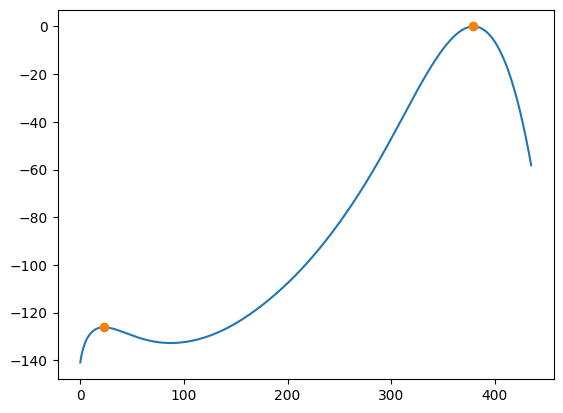

In [30]:
plt.plot(ref.data)
plt.plot(maxima_index[0], ref.data[maxima_index], marker="o", ls="None")

## Watershed

OK, great.  Now we can segment the data. `lnPi` provides a wrapper to {func}`skimage.segmentation.watershed` through {meth}`lnpy.segment.Segmenter.watershed`.

In [31]:
s = lnpy.segment.Segmenter()

In [32]:
labels = s.watershed(-ref.data, markers=maxima_marker, mask=~ref.mask)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Each unique value in `labels` corresponds to a phase.  We can construct multiple `lnPiMasked` objects from labels using

## local free energy

Now, we look at the local free energy.  The local (scaled) free energy is defined as $w(N) = \beta f(N) = -\ln \Pi(N)$. We consider the energy at the location of the local minima in $w$ (local maxima in $\ln \Pi$) versus the value of $w$ at the transition between phases (around $n=100$ in the figure above).  This is performed by the class {class}`lnpy.lnpienergy.wFreeEnergy`.  

In [33]:
from lnpy.lnpienergy import wFreeEnergy

In [34]:
w = wFreeEnergy.from_labels(data=ref.data, labels=labels)

In [35]:
# this is the same as -lnPi[maxima]
w.w_min

array([[126.12754742],
       [ -0.        ]])

In [36]:
-ref.data[maxima_index]

array([126.12754742,  -0.        ])

In [37]:
# w.w_tran[i, j] is the 'transition' energy going from phase i to phase j
w.w_tran

array([[         inf, 132.72931142],
       [132.72931142,          inf]])

In [38]:
# the transition between phases '0' and '1' is at index 87
w.w_argtran

{(0, 1): (87,)}

In [39]:
-ref.data[87]

132.72931142169

In [40]:
# the change in energy between the phases
w.delta_w

array([[         inf,   6.601764  ],
       [132.72931142,          inf]])

This transition energy means the two phases are stable.  So move on.

In [41]:
lnpis = ref.list_from_masks(w.masks)
lnpis

[<lnPi(lnz=[-3.60995641])>, <lnPi(lnz=[-3.60995641])>]

## Construct collection
Now these can be converted to a {class}`~lnpy.lnpiseries.lnPiCollection` object.

In [42]:
p = lnpy.lnPiCollection.from_list(lnpis, index=[0, 1])
p

<class lnPiCollection>
lnz_0      phase
-3.609956  0        [-3.6099564097351307]
           1        [-3.6099564097351307]
dtype: object

So, the segmentation can get pretty involved.  This is why there is the helper class {class}`~lnpy.segment.PhaseCreator`. There are a slew
of options to the different routines.  Look at the docs for more information

## At a different $\ln z$ value

Let us instead consider a different value of chemical potential. One near the critical point.  

In [43]:
p = phase_creator.build_phases(-3.49)
p

<class lnPiCollection>
lnz_0  phase
-3.49  0        [-3.49]
       1        [-3.49]
dtype: object

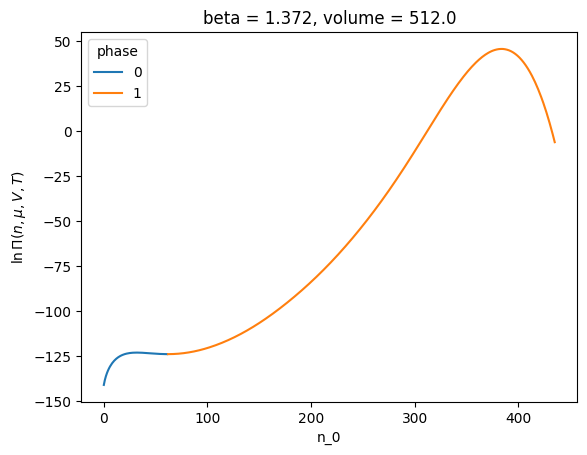

In [44]:
p.xge.lnpi().plot(hue="phase")

But lets look at the local free energy 'w' defined above.  This can be obtained by the accessor {attr}`~lnpy.lnpiseries.lnPiCollection.wfe` in {class}`~lnpy.lnpiseries.lnPiCollection`.  

In [45]:
# min(w) in each phase
p.wfe.w_min

lnz_0  phase
-3.49  0        122.930891
       1        -45.776165
Name: w_min, dtype: float64

In [46]:
# transition w from phase to phase_nebr
p.wfe.w_tran

lnz_0  phase  phase_nebr
-3.49  0      0                    inf
              1             123.785912
       1      0             123.785912
              1                    inf
Name: w_tran, dtype: float64

In [47]:
# w_tran - w_min
p.wfe.dw

lnz_0  phase  phase_nebr
-3.49  0      0                    inf
              1               0.855021
       1      0             169.562078
              1                    inf
Name: delta_w, dtype: float64

We see that the $\Delta w$ is pretty low at this value of $\ln z$.  We passed in the parameter `efac=0.8` in the definition of `phase_creator`.  If we instead wish to remove phases with an energy this low, we can do the following:

In [48]:
p = phase_creator.build_phases(-3.49, efac=0.9)
p

<class lnPiCollection>
lnz_0  phase
-3.49  0        [-3.49]
dtype: object

Now if the $\Delta w$ between phases is smaller than `efac`, the phases are merged.  For more information, see that api docs.

## Tagging phases

{class}`~lnpy.segment.PhaseCreator` allows passing a callback `tag_phases` to attach a label to each phase.  By default, the phases are labeled by there list index.  This can be confusing, because over a range of $\ln z$ values, different physical phases can have the same label.  For example

In [49]:
phase_creator = lnpy.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.8})

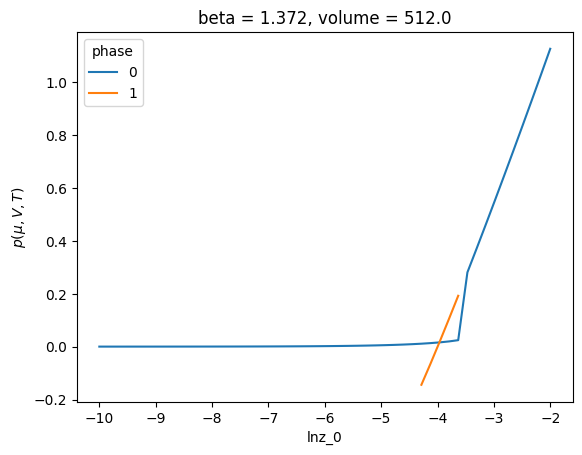

In [50]:
c = lnpy.lnPiCollection.from_builder(
    np.linspace(-10, -2, 50), build_phases=phase_creator.build_phases
)

# this looks weird because have multiple phases and not sure which is which
c.xge.pressure().plot(hue="phase")

Note that this can be fixed by considering 'stable' phases only

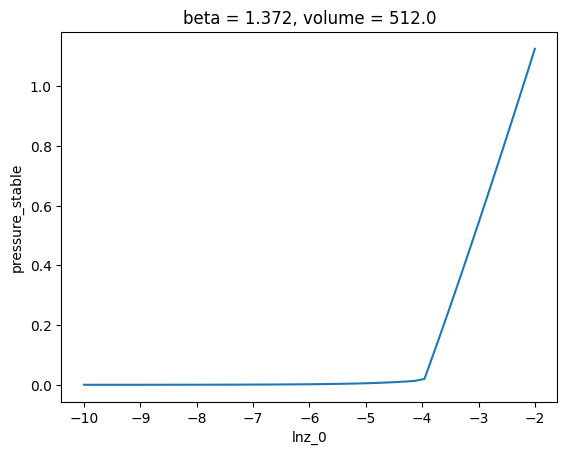

In [51]:
(
    c.xge.table(["mask_stable", "pressure"], default_keys=None)
    .assign(pressure_stable=lambda x: x["pressure"].where(x["mask_stable"]))
    .pressure_stable.max("phase")
    .plot()
)

There are two clear phases here.  It would be beneficial to label the liquid and vapor phases differently.
So we define the callback tag_phases

In [52]:
def tag_phases(list_of_phases):
    """
    Simple tag_phases callback

    This looks at the local maximum of each lnPiMasked object.

    If location of maximum < len(data)/2 -> phase = 0
    else -> phase = 1

    """
    if len(list_of_phases) > 2:
        msg = "bad tag function"
        raise ValueError(msg)
    argmax0 = np.array([xx.local_argmax()[0] for xx in list_of_phases])
    return np.where(argmax0 <= list_of_phases[0].shape[0] / 2, 0, 1)

In [53]:
phase_creator = lnpy.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.8}, tag_phases=tag_phases
)

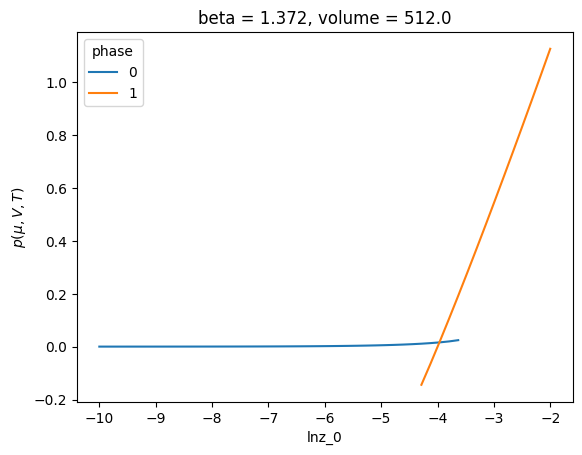

In [54]:
c = lnpy.lnPiCollection.from_builder(
    np.linspace(-10, -2, 50), build_phases=phase_creator.build_phases
)

c.xge.pressure().plot(hue="phase")

# Calculation Binodal and spinodal

The binodal and spinodal can be found using the {mod}`lnpy.stability` module.  This module adds accessors to {class}`~lnpy.lnpiseries.lnPiCollection` class.  A collection is needed to provide a decent guess for the location of the binodal and spinodal.


In [55]:
# must import stability to add the accessors to lnPiCollection
import lnpy.stability

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import lnpy
import lnpy.examples

# Subcritical LJ data
ref = lnpy.examples.load_example_lnpimasked("lj_sub")

phase_creator = lnpy.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.8}, tag_phases=tag_phases
)

# Here we need a scalar builder object.
build_phases = phase_creator.build_phases_mu([None])

In [57]:
# initial guess
c = lnpy.lnPiCollection.from_builder(
    np.linspace(-10, -2, 10), build_phases=phase_creator.build_phases_mu([None])
)

The spinodal is calculates as the location where $\Delta w$ equals some value.  Lets say we want to define the spinodal
as the location where $\Delta w = 1.0$.  We do the following:

In [58]:
_ = c.spinodal(
    phase_ids=2,  # the id's of the phases we're considering
    build_phases=phase_creator.build_phases_mu([None]),
    # this is the efac parameter for
    build_kws={"efac": 0.5},
    inplace=True,
    as_dict=False,
    efac=1.0,
)

In [59]:
# to access the data as a collection, use the `access` attribute
c.spinodal.access

<class lnPiCollection>
spinodal  lnz_0      phase
0         -3.494734  0        [-3.494734034735128]
                     1        [-3.494734034735128]
1         -4.379828  0        [-4.379828176267564]
                     1        [-4.379828176267564]
dtype: object

In [60]:
# energetics
# spinodal 0 is the limit of stability for phase 0 -> phase 1
# spinodal 1 is the limit of stability for phase 1 -> phase 0
c.spinodal.access.wfe.dw

spinodal  lnz_0      phase  phase_nebr
0         -3.494734  0      0                    inf
                            1               1.000000
                     1      0             168.038523
                            1                    inf
1         -4.379828  0      0                    inf
                            1             142.179651
                     1      0               1.000000
                            1                    inf
Name: delta_w, dtype: float64

Now that we have the spinodal, we can calculation the binodal

In [61]:
bino = c.binodal(
    phase_ids=[0, 1],
    build_phases=phase_creator.build_phases_mu([None]),
    build_kws={"efac": 0.5},
    inplace=True,
)

In [62]:
# access as collection with the `access` attribute
c.binodal.access

<class lnPiCollection>
binodal  lnz_0      phase
0        -3.966438  0        [-3.966438059499727]
                    1        [-3.966438059499727]
dtype: object

In [63]:
# at the binodal, the two phases should have equal pressure
c.binodal.access.xge.pressure()

<xarray.DataArray 'pressure' (binodal: 1, lnz_0: 1, phase: 2)> Size: 16B
array([[[0.01594237, 0.01594237]]])
Coordinates:
  * binodal  (binodal) int64 8B 0
  * lnz_0    (lnz_0) float64 8B -3.966
  * phase    (phase) int64 16B 0 1
    beta     float64 8B 1.372
    volume   float64 8B 512.0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   $p(\mu,V,T)$

To append spinodal/binodal to the dataset, use the following:

In [64]:
c_total = c.append(c.spinodal.appender).append(c.binodal.appender)
c_total

<class lnPiCollection>
lnz_0       phase
-10.000000  0                      [-10.0]
-9.111111   0          [-9.11111111111111]
-8.222222   0         [-8.222222222222221]
-7.333333   0         [-7.333333333333334]
-6.444444   0         [-6.444444444444445]
-5.555556   0         [-5.555555555555555]
-4.666667   0         [-4.666666666666667]
-3.777778   0        [-3.7777777777777786]
            1        [-3.7777777777777786]
-2.888889   1        [-2.8888888888888893]
-2.000000   1                       [-2.0]
-3.494734   0         [-3.494734034735128]
            1         [-3.494734034735128]
-4.379828   0         [-4.379828176267564]
            1         [-4.379828176267564]
-3.966438   0         [-3.966438059499727]
            1         [-3.966438059499727]
dtype: object

and if you'd like to sort the index:

In [65]:
c_total.sort_index()

<class lnPiCollection>
lnz_0       phase
-10.000000  0                      [-10.0]
-9.111111   0          [-9.11111111111111]
-8.222222   0         [-8.222222222222221]
-7.333333   0         [-7.333333333333334]
-6.444444   0         [-6.444444444444445]
-5.555556   0         [-5.555555555555555]
-4.666667   0         [-4.666666666666667]
-4.379828   0         [-4.379828176267564]
            1         [-4.379828176267564]
-3.966438   0         [-3.966438059499727]
            1         [-3.966438059499727]
-3.777778   0        [-3.7777777777777786]
            1        [-3.7777777777777786]
-3.494734   0         [-3.494734034735128]
            1         [-3.494734034735128]
-2.888889   1        [-2.8888888888888893]
-2.000000   1                       [-2.0]
dtype: object

# Multi component systems

lnPi is designed to work with single and multicomponent systems.   Let's take a look at a system without phase transitions to start.  

In [66]:
import lnpy.examples

In [67]:
data = lnpy.examples.load_example_dict("ljmix_sup")

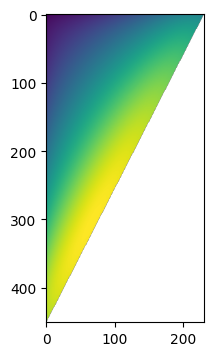

In [68]:
f, a = plt.subplots(figsize=(4, 4))
a.imshow(data["lnPi_data"])

We have finite data along the upper corner of the matrix 'lnPi_data'. Therefore, the base `lnPiMasked` object, without splitting into phases, also will have a mask.  This is why everything was build up from the `numpy.ma.MaskedArray` class. 

In [69]:
data

{'lnPi_data': array([[-759.26449941, -756.19423037, -753.77081946, ..., -424.28411489,
         -425.66274776, -426.93571412],
        [-755.52637941, -752.42375982, -749.96557613, ..., -418.59148639,
         -419.73805248,           nan],
        [-752.45715941, -749.31971691, -746.82151608, ..., -413.26963103,
         -414.54424182,           nan],
        ...,
        [-104.40479985, -102.4117824 ,           nan, ...,           nan,
                   nan,           nan],
        [-105.98668385,           nan,           nan, ...,           nan,
                   nan,           nan],
        [-107.62349885,           nan,           nan, ...,           nan,
                   nan,           nan]]),
 'lnPi_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False,  True],
        ...,
        [False, False,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,

In [70]:
ref = lnpy.lnPiMasked.from_data(
    lnz=data["lnz"],
    lnz_data=data["lnz"],
    data=data["lnPi_data"],
    mask=data["lnPi_mask"],
    state_kws=data["state_kws"],
    extra_kws=data["extra_kws"],
)

Note that we could have also done:

In [71]:
ref = lnpy.lnPiMasked.from_data(
    lnz=data["lnz"],
    lnz_data=data["lnz"],
    data=data["lnPi_data"],
    mask=np.isnan(data["lnPi_data"]),
    state_kws=data["state_kws"],
    extra_kws=data["extra_kws"],
)

## Considering lines of constant $\ln z$ or constant $\Delta \ln z$.

Considering a multicomponent system will hopefully help explain why some design choices were made for `lnpy`.

It is common to want to consider a multicomponent system along lines of constant 'something'.  For example, we might want to consider a spectrum of values of $\ln z_0$ while holding $\ln z_1$ constant.  This can be accomplished using some built in {class}`~lnpy.segment.PhaseCreator` constructors. 

First, note that if you know that a particular system will not have a phase transition, specify `nmax=1`.  This will make the system skip the `lnPi` segmentation, which is the slowest process in analyzing $\ln \Pi(N)$.  

In [72]:
phase_creator = lnpy.PhaseCreator(nmax=1, ref=ref)

If you just call the `phase_creator.build_phases` constructor, we have to specify the total (vector) value of $\ln z$.

In [73]:
phase_creator.build_phases(lnz=[0.0, 0.0])

<class lnPiCollection>
lnz_0  lnz_1  phase
0.0    0.0    0        [0.0, 0.0]
dtype: object

This is fine.  But things like {class}`~lnpy.lnpiseries.lnPiCollection`, {class}`~lnpy.stability.Spinodals`, and {class}`~lnpy.stability.Binodals` are setup to work with scalar values of $\ln z$.  So, we have the following constructors:

In [74]:
build_phases = phase_creator.build_phases_mu([None, -1.0])

In [75]:
build_phases(0.0)

<class lnPiCollection>
lnz_0  lnz_1  phase
0.0    -1.0   0        [0.0, -1.0]
dtype: object

{meth}`~lnpy.segment.PhaseCreator.build_phases_mu` returns a constructor at fixed values of $\ln z$ for all but one component. The component given a value of None (the first component in the example above) is the one we can vary.  Then calling this constructor will make a new collection with the requested value of $\ln z$ for the variable component and the fixed values of $\ln z$ for other components as defined in the constructor.  

We can use this to define a collection easily

In [76]:
c = lnpy.lnPiCollection.from_builder(np.linspace(-3, 3, 5), build_phases)

c

<class lnPiCollection>
lnz_0  lnz_1  phase
-3.0   -1.0   0        [-3.0, -1.0]
-1.5   -1.0   0        [-1.5, -1.0]
 0.0   -1.0   0         [0.0, -1.0]
 1.5   -1.0   0         [1.5, -1.0]
 3.0   -1.0   0         [3.0, -1.0]
dtype: object

In [77]:
# At a different fixed value.  This time at fixed lnz_0
build_phases = phase_creator.build_phases_mu([0.5, None])
c = lnpy.lnPiCollection.from_builder(
    lnzs=np.linspace(-3, 3, 5), build_phases=build_phases
)
c

<class lnPiCollection>
lnz_0  lnz_1  phase
0.5    -3.0   0        [0.5, -3.0]
       -1.5   0        [0.5, -1.5]
        0.0   0         [0.5, 0.0]
        1.5   0         [0.5, 1.5]
        3.0   0         [0.5, 3.0]
dtype: object

Similarly, we can create `lnPi`s at fixed value of $\Delta \ln z$, where $\Delta \ln z_k = \ln z_k - \ln z_f$ where $f$ is the index of the variable component using the {meth}`~lnpy.segment.PhaseCreator.build_phases_dmu` method:

In [78]:
# fixed value of dlnz_1 = lnz_1 - lnz_0 = 1.0
build_phases = phase_creator.build_phases_dmu([None, 1.0])
c = lnpy.lnPiCollection.from_builder(
    lnzs=np.linspace(-3, 3, 5), build_phases=build_phases
)
c

<class lnPiCollection>
lnz_0  lnz_1  phase
-3.0   -2.0   0        [-3.0, -2.0]
-1.5   -0.5   0        [-1.5, -0.5]
 0.0    1.0   0          [0.0, 1.0]
 1.5    2.5   0          [1.5, 2.5]
 3.0    4.0   0          [3.0, 4.0]
dtype: object

In [79]:
lnz_0 = c.get_index_level("lnz_0")
lnz_1 = c.get_index_level("lnz_1")

In [80]:
lnz_1 - lnz_0

Index([1.0, 1.0, 1.0, 1.0, 1.0], dtype='float64')

## Multicomponent system with phase transitions

Next, we consider a multicomponent system 

In [81]:
ref = lnpy.examples.load_example_lnpimasked("hsmix")
ref

<lnPi(lnz=[0.5 0.5])>

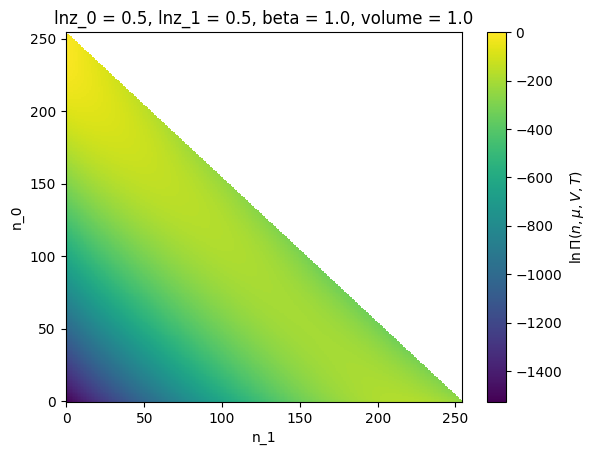

In [82]:
ref.xge.lnpi().plot()

In [83]:
# function to tag 'LD' and 'HD' phases
def tag_phases(x):
    if len(x) > 2:
        msg = "bad tag function"
        raise ValueError(msg)
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


phase_creator = lnpy.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref, tag_phases=tag_phases, merge_kws={"efac": 0.8}
)

In [84]:
build_phases = phase_creator.build_phases_mu([None, 0.0])

c = lnpy.lnPiCollection.from_builder(
    np.linspace(-5, 5, 50), build_phases, unstack=False
)
c

<class lnPiCollection>
lnz_0      lnz_1  phase
-5.000000  0.0    0                      [-5.0, 0.0]
-4.795918  0.0    0        [-4.795918367346939, 0.0]
-4.591837  0.0    0        [-4.591836734693878, 0.0]
-4.387755  0.0    0        [-4.387755102040816, 0.0]
-4.183673  0.0    0        [-4.183673469387755, 0.0]
                                     ...            
 4.183673  0.0    1         [4.183673469387756, 0.0]
 4.387755  0.0    1         [4.387755102040817, 0.0]
 4.591837  0.0    1         [4.591836734693878, 0.0]
 4.795918  0.0    1         [4.795918367346939, 0.0]
 5.000000  0.0    1                       [5.0, 0.0]
Length: 65, dtype: object

Note that here we have used the `unstack=False` option.  This means that the results from {attr}`lnpy.lnpiseries.lnPiCollection.xge` will *not* be unstacked.  For example:

In [85]:
c.xge.betaOmega()

<xarray.DataArray 'betaOmega' (sample: 65)> Size: 520B
array([-1246.12388491, -1246.12448998, -1246.12523222, -1246.12614278,
       -1246.12725991, -1246.1286306 , -1246.13031256, -1246.13237676,
       -1246.13491046, -1246.13802107, -1246.14184087, -1246.14653294,
       -1246.15229859, -1246.1593867 , -1246.16810551, -1246.1788377 ,
       -1246.19205972, -1010.9087438 , -1246.20836701, -1054.37219518,
       -1246.22850704, -1098.99423283, -1246.25342379, -1144.4775693 ,
       -1246.28431829, -1190.70729484, -1246.32273372, -1237.62335537,
       -1246.37067871, -1285.1875377 , -1246.43081409, -1333.37342804,
       -1246.50675309, -1382.15798324, -1246.60358765, -1431.51759825,
       -1246.72896095, -1481.42620374, -1246.89609727, -1531.84252007,
       -1247.1319439 , -1582.68976406, -1247.47204378, -1633.86017062,
       -1247.86446355, -1685.24884688, -1736.77785101, -1788.39701972,
       -1840.07559237, -1891.79461328, -1943.54206924, -1995.3100774 ,
       -2047.093286  , -2098.88794914, -2150.69137525, -2202.50158717,
       -2254.3171055 , -2306.13680626, -2357.95982463, -2409.78548824,
       -2461.61326981, -2513.44275296, -2565.27360693, -2617.10556771,
       -2668.9384238 ])
Coordinates:
  * sample   (sample) object 520B MultiIndex
  * lnz_0    (sample) float64 520B -5.0 -4.796 -4.592 -4.388 ... 4.592 4.796 5.0
  * lnz_1    (sample) float64 520B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * phase    (sample) int64 520B 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    beta     float64 8B 1.0
    volume   float64 8B 1.0
Attributes:
    dims_n:         ['n_0', 'n_1']
    dims_lnz:       ['lnz_0', 'lnz_1']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'lnz_1', 'beta', 'volume']
    dims_rec:       ['sample']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

To 'unstack' from 'sample' dimension to 'lnz_0', 'lnz_1', etc, you can call `unstack` directly:

In [86]:
c.xge.betaOmega().unstack()

<xarray.DataArray 'betaOmega' (lnz_0: 50, lnz_1: 1, phase: 2)> Size: 800B
array([[[-1246.12388491,            nan]],

       [[-1246.12448998,            nan]],

       [[-1246.12523222,            nan]],

       [[-1246.12614278,            nan]],

       [[-1246.12725991,            nan]],

       [[-1246.1286306 ,            nan]],

       [[-1246.13031256,            nan]],

       [[-1246.13237676,            nan]],

       [[-1246.13491046,            nan]],

       [[-1246.13802107,            nan]],

...

       [[           nan, -2202.50158717]],

       [[           nan, -2254.3171055 ]],

       [[           nan, -2306.13680626]],

       [[           nan, -2357.95982463]],

       [[           nan, -2409.78548824]],

       [[           nan, -2461.61326981]],

       [[           nan, -2513.44275296]],

       [[           nan, -2565.27360693]],

       [[           nan, -2617.10556771]],

       [[           nan, -2668.9384238 ]]])
Coordinates:
  * lnz_0    (lnz_0) float64 400B -5.0 -4.796 -4.592 -4.388 ... 4.592 4.796 5.0
  * lnz_1    (lnz_1) float64 8B 0.0
  * phase    (phase) int64 16B 0 1
    beta     float64 8B 1.0
    volume   float64 8B 1.0
Attributes:
    dims_n:         ['n_0', 'n_1']
    dims_lnz:       ['lnz_0', 'lnz_1']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'lnz_1', 'beta', 'volume']
    dims_rec:       ['sample']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

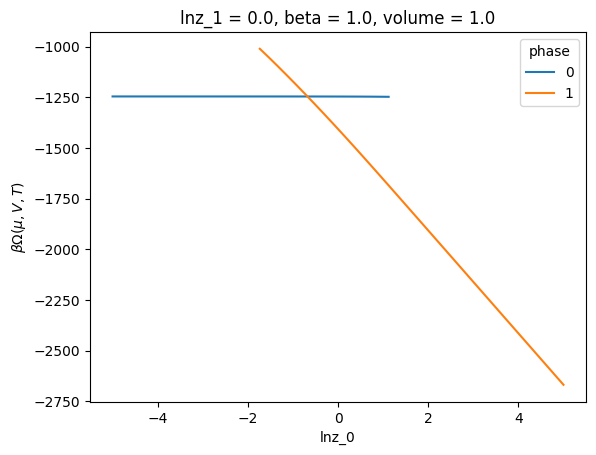

In [87]:
c.xge.betaOmega().unstack().plot(hue="phase")

In [88]:
# spinodal along line of constant lnz_2

_ = c.spinodal(phase_ids=[0, 1], build_phases=build_phases, efac=1.0, inplace=True)
_ = c.binodal(phase_ids=[0, 1], build_phases=build_phases, inplace=True)

In [89]:
# create table for spinodal/binodal

t_spin = c.spinodal.access.xge.table(["molfrac"], ref=ref)
t_bino = c.binodal.access.xge.table(["molfrac"], ref=ref)

In [90]:
t_spin

<xarray.Dataset> Size: 368B
Dimensions:        (sample: 4, component: 2)
Coordinates:
  * sample         (sample) object 32B MultiIndex
  * spinodal       (sample) int64 32B 0 0 1 1
  * lnz_0          (sample) float64 32B 1.202 1.202 -1.806 -1.806
  * lnz_1          (sample) float64 32B 0.0 0.0 0.0 0.0
  * phase          (sample) int64 32B 0 1 0 1
    beta           float64 8B 1.0
    volume         float64 8B 1.0
Dimensions without coordinates: component
Data variables:
    edge_distance  (sample) float64 32B 31.11 1.0 31.11 29.7
    molfrac        (sample, component) float64 64B 0.01297 0.987 ... 0.02102
    nvec           (sample, component) float64 64B 2.715 206.5 ... 206.7 4.438
    betapV         (sample) float64 32B 1.248e+03 1.705e+03 1.246e+03 996.1
Attributes:
    dims_n:      ['n_0', 'n_1']
    dims_lnz:    ['lnz_0', 'lnz_1']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'lnz_1', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   distance from upper edge

In [91]:
t_spin.reset_index("sample").to_dataframe().query(
    "component==0 and spinodal==phase"
).dropna()

,,spinodal,lnz_0,lnz_1,phase,beta,volume,edge_distance,molfrac,nvec,betapV
sample,component,,,,,,,,,,
0,0,0,1.201575,0.0,0,1.0,1.0,31.112698,0.012974,2.714673,1248.009992
3,0,1,-1.805724,0.0,1,1.0,1.0,29.698485,0.978978,206.675356,996.095608


doing this for multiple values of fixed `lnz_1`:

In [92]:
from joblib import Parallel, delayed


def get_bin_spin1(lnz2, phase_creator, from_builder, from_builder_kws=None):
    # reload stability here to make sure accessor available (also make sure black keeps this here.)

    build_phases = phase_creator.build_phases_mu([None, lnz2])
    lnzs = np.linspace(-8, 8, 20)
    if from_builder_kws is None:
        from_builder_kws = {}
    c = from_builder(lnzs, build_phases, **from_builder_kws)
    t_spin = None
    t_bino = None

    try:
        c.spinodal(2, build_phases, inplace=True, unstack=False)
        c.binodal(2, build_phases, inplace=True, unstack=False)
        t_spin = c.spinodal.access.xge.table(["molfrac"], ref=ref)
        t_bino = c.binodal.access.xge.table(["molfrac"], ref=ref)
    except Exception:  # noqa: BLE001
        pass
    return t_spin, t_bino

In [93]:
out1 = Parallel(n_jobs=-1)(
    delayed(get_bin_spin1)(lnz2, phase_creator, lnpy.lnPiCollection.from_builder)
    for lnz2 in np.arange(-5, 5, 0.5)
)

In [94]:
spin1 = xr.concat([s for s, b in out1 if s is not None], "sample")
bino1 = xr.concat([b for s, b in out1 if b is not None], "sample")

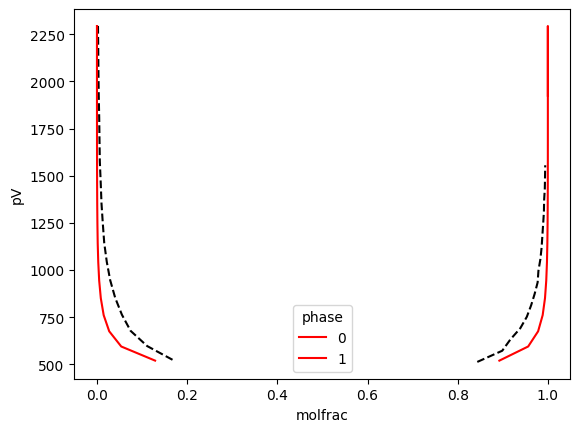

In [95]:
def plot_frame(df, **kws) -> None:
    (
        df.reset_index()
        .set_index(["molfrac", "phase"])
        .assign(pV=lambda x: x["betapV"] / x["beta"])["pV"]
        .to_xarray()
        .plot(hue="phase", **kws)
    )


plot_frame(
    spin1.reset_index("sample")
    .to_dataframe()
    .query("component==0 and spinodal==phase")
    .dropna(),
    ls="--",
    color="k",
)
plot_frame(
    bino1.reset_index("sample").to_dataframe().query("component==0").dropna(), color="r"
)